In [1]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdFMCS
from matplotlib import pyplot as plt
import time
import seaborn as sns

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


# Load data

In [2]:
group_cols = ['UniProt_ID', 'Template', 'Docked']


df_fil = pd.read_csv('../data/cross_template_docking_results.csv')
df_fil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404068 entries, 0 to 1404067
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   UniProt_ID   1404068 non-null  object 
 1   Template     1404068 non-null  object 
 2   Docked       1404068 non-null  object 
 3   Pose         1404068 non-null  int64  
 4   flexx_rmsd   1368967 non-null  float64
 5   flexx_score  1404068 non-null  float64
 6   hyde_rmsd    1368967 non-null  float64
 7   hyde_score   1404068 non-null  float64
 8   mcs_rmsd     1226676 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 96.4+ MB


In [3]:
df_fil = df_fil.dropna().reset_index(drop=True)
df_fil = df_fil[df_fil.mcs_rmsd <= 2]
df_fil

,UniProt_ID,Template,Docked,Pose,flexx_rmsd,flexx_score,hyde_rmsd,hyde_score,mcs_rmsd
13,O14757,3TKH_07S,4HYI_1AO,4,11.111,452.90,11.651,4.082462e+10,1.945
15,O14757,3TKH_07S,4HYI_1AO,6,11.348,453.93,11.084,5.266786e+10,1.270
20,O14757,3TKH_07S,2HXQ_373,1,9.914,42.19,9.680,1.675378e+08,1.959
21,O14757,3TKH_07S,2HXQ_373,2,10.062,42.53,9.884,4.683320e+08,1.953
22,O14757,3TKH_07S,2HXQ_373,3,10.564,46.09,10.429,2.818725e+07,1.836
...,...,...,...,...,...,...,...,...,...
1199182,Q9GPQ4,3EPW_JMQ,3B9G_IMH,6,0.850,1518.83,0.894,2.188910e+06,0.777
1199183,Q9GPQ4,3EPW_JMQ,3B9G_IMH,7,0.810,1568.03,0.945,3.474792e+12,0.729
1199184,Q9GPQ4,3EPW_JMQ,3B9G_IMH,8,0.815,1615.20,0.859,1.960301e+08,0.726
1199185,Q9GPQ4,3EPW_JMQ,3B9G_IMH,9,0.771,1647.62,0.951,3.830439e+06,0.720


In [4]:
df_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732360 entries, 13 to 1199186
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UniProt_ID   732360 non-null  object 
 1   Template     732360 non-null  object 
 2   Docked       732360 non-null  object 
 3   Pose         732360 non-null  int64  
 4   flexx_rmsd   732360 non-null  float64
 5   flexx_score  732360 non-null  float64
 6   hyde_rmsd    732360 non-null  float64
 7   hyde_score   732360 non-null  float64
 8   mcs_rmsd     732360 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 55.9+ MB


In [5]:
df_fil = df_fil.loc[df_fil.groupby(group_cols)['hyde_score'].idxmin()].reset_index(drop=True)
df_fil

,UniProt_ID,Template,Docked,Pose,flexx_rmsd,flexx_score,hyde_rmsd,hyde_score,mcs_rmsd
0,O14757,1NVQ_UCN,1NVR_STU,6,0.587,1160.65,0.538,5.507498e+02,0.539
1,O14757,1NVQ_UCN,2HY0_306,7,11.087,3175.73,11.073,5.179495e+07,1.244
2,O14757,1NVQ_UCN,2XF0_4UB,5,2.880,116.36,2.648,8.049964e+08,1.677
3,O14757,1NVQ_UCN,2YER_TQ1,4,6.539,26.32,7.455,1.157508e+06,1.271
4,O14757,1NVQ_UCN,4HYI_1AO,7,7.284,2.95,6.926,1.793905e+07,0.472
...,...,...,...,...,...,...,...,...,...
82850,Q54276,7C34_BER,1W1V_ALJ,1,6.059,28.42,7.668,1.542098e+08,1.570
82851,Q8I3X4,1NW4_IMH,1Q1G_MTI,3,1.244,1136.72,0.749,1.872076e+05,0.404
82852,Q8I3X4,1NW4_IMH,6AQS_IM5,3,1.684,646.56,2.000,8.690392e+06,0.413
82853,Q8I3X4,6AQS_IM5,1Q1G_MTI,6,1.729,914.37,1.270,2.525309e+09,0.475


In [6]:
df_fil.hyde_rmsd.describe()

count    82855.000000
mean         4.871740
std          3.179807
min          0.111000
25%          2.192000
50%          4.054000
75%          7.313500
max         29.393000
Name: hyde_rmsd, dtype: float64

In [8]:
round(len(df_fil[df_fil.hyde_rmsd <= 2])/len(df_fil), 2)

0.22

# Filter docking results with chemcal series

In [9]:
BASE = '..'
PATH_TO_RMSD = f'{BASE}/data'
PATH_TO_PREPROCESSED = f'{BASE}/preprocessed_data'
PATH_TO_OUTPUT = f'{BASE}/clustering_output/'
PATH_TO_ANALYSIS = f'{BASE}/clusters_analysis/'

df = pd.read_csv(f'../data/astex_selected_for_docking.csv', usecols=['UniProt_ID', 'PDB', 'Lig', 'Smiles_String'])
df = df[df.UniProt_ID != 'P04818']
uniprots = df.UniProt_ID.unique()
len(uniprots)

71

In [10]:
frames = []

for uni in uniprots:
    mcs_dict = pd.read_csv(f'{PATH_TO_OUTPUT}/{uni}/{uni}_MCS_dict.csv', index_col=0).to_dict()
    for _ in list(mcs_dict.keys()):
        lig_names = []
        smiles = []
        with open(f'{PATH_TO_ANALYSIS}/{uni}/{_}/Matches_Smiles_Ligand_Name.txt', 'r') as f:
            for line in f:
                smiles.append(line.split('  ')[0])
                lig_names.append(line.split('  ')[1][:-1])
        temp_df = df_fil.loc[(df_fil['Template'].isin(lig_names)) &
                             (df_fil['Docked'].isin(lig_names))].copy()
        temp_df['Cluster_ID'] = _
        temp_df['cluster_mcs'] = mcs_dict[_][2]
        frames.append(temp_df)

final = pd.concat(frames, ignore_index=True)


In [11]:
final

,UniProt_ID,Template,Docked,Pose,flexx_rmsd,flexx_score,hyde_rmsd,hyde_score,mcs_rmsd,Cluster_ID,cluster_mcs
0,O14757,3OT3_22K,3OT8_MI5,7,1.469,2078.54,1.483,2.846684e+04,0.968,110,[#6]-[#7]1:[#6]:[#6](:[#6]:[#7]:1)-[#6]1:[#6]:...
1,O14757,3OT8_MI5,3OT3_22K,4,1.091,1996.60,0.952,3.476951e+05,1.081,110,[#6]-[#7]1:[#6]:[#6](:[#6]:[#7]:1)-[#6]1:[#6]:...
2,O14757,2BR1_PFP,2BRH_DFW,9,1.456,4950.68,1.222,5.107738e+07,0.567,133,"[#6]1:[#7,#8]:[#6](:[#6]:[#7,#6]:[#6](:[#7]:[#..."
3,O14757,2BR1_PFP,2CGX_3D3,5,4.902,-13.90,4.837,1.961291e+08,0.821,133,"[#6]1:[#7,#8]:[#6](:[#6]:[#7,#6]:[#6](:[#7]:[#..."
4,O14757,2BRB_PFQ,2CGX_3D3,8,6.486,-12.39,6.664,1.004928e+09,0.965,133,"[#6]1:[#7,#8]:[#6](:[#6]:[#7,#6]:[#6](:[#7]:[#..."
...,...,...,...,...,...,...,...,...,...,...,...
13606,Q54276,1W1Y_TYP,1W1V_ALJ,10,1.534,276.12,1.034,3.479824e+05,0.571,7,[#6]1-[#6]-[#6]2-[#7](-[#6]-1)-[#6](-[#6]-[#7]...
13607,Q8I3X4,1NW4_IMH,1Q1G_MTI,3,1.244,1136.72,0.749,1.872076e+05,0.404,4,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...
13608,Q8I3X4,1NW4_IMH,6AQS_IM5,3,1.684,646.56,2.000,8.690392e+06,0.413,4,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...
13609,Q8I3X4,6AQS_IM5,1Q1G_MTI,6,1.729,914.37,1.270,2.525309e+09,0.475,4,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...


In [12]:
round(len(final[final.hyde_rmsd <= 2])/len(final), 2)

0.48

In [15]:
df_fil['label'] = np.where(df_fil['hyde_rmsd'] <= 2, 1, 0)
final['label'] = np.where(final['hyde_rmsd'] <= 2, 1, 0)

In [18]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UniProt_ID   13611 non-null  object 
 1   Template     13611 non-null  object 
 2   Docked       13611 non-null  object 
 3   Pose         13611 non-null  int64  
 4   flexx_rmsd   13611 non-null  float64
 5   flexx_score  13611 non-null  float64
 6   hyde_rmsd    13611 non-null  float64
 7   hyde_score   13611 non-null  float64
 8   mcs_rmsd     13611 non-null  float64
 9   Cluster_ID   13611 non-null  object 
 10  cluster_mcs  13611 non-null  object 
 11  label        13611 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 1.2+ MB


In [21]:
# Get percentage per label for each dataset
df_fil_bins = df_fil['label'].value_counts(normalize=True).rename('df_fil') * 100
final_bins = final['label'].value_counts(normalize=True).rename('final') * 100

# Combine into one DataFrame
label_bins = pd.concat([df_fil_bins, final_bins], axis=1).reindex([0, 1])
label_bins.index.name = 'label'
label_bins = label_bins.reset_index()
label_bins = label_bins.rename(columns={'df_fil': 'Before filtering',
                                        'final': 'After filtering'})

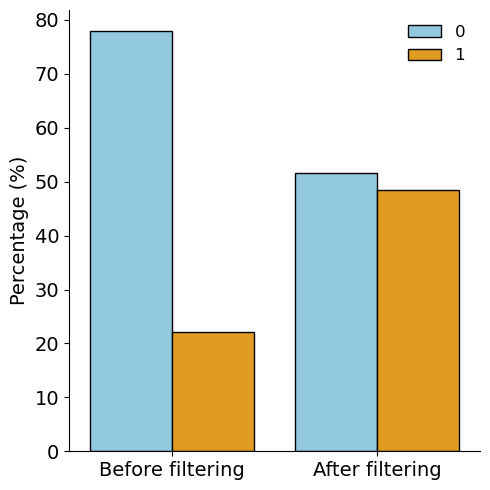

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt for plotting
plot_df = label_bins.melt(id_vars='label', var_name='Dataset', value_name='Percentage')

plt.figure(figsize=(5, 5))

custom_palette = {0: 'skyblue', 1: 'orange'}

ax = sns.barplot(data=plot_df, x='Dataset', y='Percentage', hue='label', palette=custom_palette, edgecolor='black')

plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title=False, frameon=False, fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Remove the x-axis label completely
ax.set_xlabel('')

plt.tight_layout()

plt.savefig('../images/before_after_balancing.png', dpi=300)

plt.show()


In [71]:
final = final.drop(columns=['flexx_rmsd', 'flexx_score', 'hyde_score', 'mcs_rmsd'])

final.to_csv('../data/filtered_template_basesd_docking.csv', index=False)

In [28]:
print("df_fil label counts:")
print(df_fil['Label'].value_counts(normalize=True) * 100)

print("\nfinal label counts:")
print(final['Label'].value_counts(normalize=True) * 100)

df_fil label counts:
Label
0    77.93736
1    22.06264
Name: proportion, dtype: float64

final label counts:
Label
0    52.545913
1    47.454087
Name: proportion, dtype: float64
